# Import

In [1]:
import os
import matplotlib.pyplot as plt
plt.close('all')
import dfm_tools as dfmt
import hydrolib.core.dflowfm as hcdfm 
import xarray as xr
import pandas as pd
import numpy as np
import contextily as ctx

import solara
import solara.lab
from ipyleaflet import Map, basemaps, ImageOverlay
import datetime
from pathlib import Path
import tempfile


# Initial set-ups, definitions, etc.

In [9]:
m = solara.reactive(Map(center=(55.5, 3), zoom=2, scroll_wheel_zoom=True,basemap=basemaps.OpenStreetMap.Mapnik)) 


def reset_map():
    m.set(Map(center=(lat_min.value+(lat_max.value-lat_min.value)*0.5, lon_min.value+(lon_max.value-lon_min.value)*0.5), 
                zoom=4, scroll_wheel_zoom=True, basemap=basemaps.OpenStreetMap.Mapnik))



# 2) User Input

NEW:

In [10]:
####################################### User Input ########################################
model_name = solara.reactive("Model Name")
continuous_update = solara.reactive(True)

model_resolution_options = ["0.05", "0.5"]
dxy = solara.reactive("0.5")

lat_min = solara.reactive(0.0); lat_max = solara.reactive(0.0); lon_min = solara.reactive(0.0); lon_max = solara.reactive(0.0)
# def reset_map(): #########################################################################################################################################################################################################################
#     m.set(Map(center=(lat_min.value+(lat_max.value-lat_min.value)*0.5, lon_min.value+(lon_max.value-lon_min.value)*0.5), 
#               zoom=5, scroll_wheel_zoom=True, basemap=basemaps.OpenStreetMap.Mapnik))

date_min = solara.reactive(datetime.date(2022, 11, 1))
date_max = solara.reactive(datetime.date(2022, 11, 3))
ref_date = solara.reactive(datetime.date(2022, 1, 1))

dir_output = solara.reactive("C:\\") # os.path.abspath(f'./{model_name}_model')
def makedir():
    dir_path = Path(dir_output.value)  
    os.makedirs(dir_path, exist_ok=True)
    dir_output_data = dir_path / 'data'
    os.makedirs(dir_output_data, exist_ok=True)
overwrite = False # used for downloading of forcing data. Always set to True when changing the domain
crs = 'EPSG:4326' # coordinate reference system

# ----------------------------------------------------------------------------------------------------

@solara.component
def Tab_User_Input():
    solara.use_effect(reset_map, dependencies=[lat_min.value, lat_max.value, lon_min.value, lon_max.value])
    with solara.Card("User Input", style={"width": "100%", "padding": "10px"}):
        solara.Markdown("""**Note to the user**: In this notebook we use publicly available data 
                        from Copernicus Programme of the European Union. To access this data you 
                        need to create accounts at 
                        [Copernicus Marine Service](https://data.marine.copernicus.eu/register)
                        and the [Climate Data Store](https://cds.climate.copernicus.eu/profile).
                        Do not forget to accept the CDS license agreement.""")
        solara.InputText("Model Name", value=model_name, continuous_update=continuous_update.value)
        solara.InputText("Output directory", value=dir_output, continuous_update=True) # --------- Only works for now as input text, file explorer not successful yet
        solara.Button(label="Select/Create directory",on_click=makedir)

        solara.Markdown("Area of Model & Resolution:")
        solara.InputFloat("Latitude minimum", value=lat_min, continuous_update=True)# continuous_update.value)
        solara.InputFloat("Latitude maximum", value=lat_max, continuous_update=True)# continuous_update.value)
        solara.InputFloat("Longitude minimum", value=lon_min, continuous_update=True)# continuous_update.value)
        solara.InputFloat("Longitude maximum", value=lon_max, continuous_update=True)# continuous_update.value)
        solara.Select(label="Model Resolution", value=dxy, values=model_resolution_options)

        solara.Markdown("Date selection:")
        solara.Text("Select min date:"); solara.lab.InputDate(date_min)
        solara.Text("Select max date:"); solara.lab.InputDate(date_max)
        solara.Text("Select reference date:"); solara.lab.InputDate(ref_date)
        if date_max.value < date_min.value:
            solara.Markdown("**Warning**: The end date cannot be earlier than the start date.", 
                            style={"color": "red"})
            
# Tab_User_Input()

In [ ]:
# Outputs I have and might need later:
# model_name.value # --> model name
# dir_output.value # --> path for output; looks different when doing print() --> MIGHT NEED SPECIAL ATTENTION/HANDLING LATER!!!!
# lat_min.value # --> lat_min; same with lat_max and lon_min, lon_max
# float(dxy.value) # --> resolution as number
# date_min.value.strftime("%Y-%m-%d") # --> date min in approriate format
# date_max.value.strftime("%Y-%m-%d") # --> date max in approriate format
# ref_date.value.strftime("%Y-%m-%d") # --> ref date in approriate format

# 3) Grid Generation and Refinement

code (successful, from notebook) to be implemented in widget

In [ ]:
# grid code from notebook

# generate spherical regular grid
mk_object = dfmt.make_basegrid(lon_min.value, lon_max.value, lat_min.value, lat_max.value, dx=float(dxy.value), dy=float(dxy.value), crs=crs)


# generate plifile from grid extent and coastlines
bnd_gdf = dfmt.generate_bndpli_cutland(mk=mk_object, res='h', buffer=0.01)
bnd_gdf_interp = dfmt.interpolate_bndpli(bnd_gdf, res=0.03)
pli_polyfile = dfmt.geodataframe_to_PolyFile(bnd_gdf_interp, name=f'{model_name.value}_bnd')
poly_file = os.path.join(dir_output.value, f'{model_name.value}.pli')
pli_polyfile.save(poly_file)


# plot basegrid and polyline
fig, ax = plt.subplots()
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
bnd_gdf_interp.plot(ax=ax, edgecolor='r')
# ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)

save first as geotiff and then try to overlay on top of m

In [8]:
# save grid as geo tif
#help(mk_object.mesh2d_get())

node_x = mk_object.mesh2d_get().node_x
node_y = mk_object.mesh2d_get().node_y
edge_nodes = mk_object.mesh2d_get().edge_nodes

edge_pairs = edge_nodes.reshape(-1, 2)  

import rasterio
from rasterio.features import rasterize
from shapely.geometry import LineString, mapping

edges_geometry = [
    LineString([(node_x[start], node_y[start]), (node_x[end], node_y[end])])
    for start, end in edge_pairs
]

min_x, max_x = node_x.min(), node_x.max()
min_y, max_y = node_y.min(), node_y.max()

resolution = float(dxy.value) 
width = int((max_x - min_x) / resolution)
height = int((max_y - min_y) / resolution)

transform = rasterio.transform.from_bounds(min_x, min_y, max_x, max_y, width, height)

raster_data = np.zeros((height, width), dtype=np.uint8)
shapes = ((mapping(geom), 1) for geom in edges_geometry)  # Assign value 1 to edges
rasterized = rasterize(
    shapes=shapes,
    out_shape=raster_data.shape,
    transform=transform,
    fill=0,  # Background value
    dtype=np.uint8,
)

# Save the rasterized data as a GeoTIFF
output_tif = os.path.join(dir_output.value, f"{model_name.value}_grid.tif")
with rasterio.open(
    output_tif,
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,  # Single band
    dtype=rasterized.dtype,
    crs=crs,  # Coordinate Reference System
    transform=transform,
) as dst:
    dst.write(rasterized, 1)

# print(f"GeoTIFF saved to: {output_tif}")

In [ ]:
# TRY TO GET TIFF NOW ON TOP OF MAP!!! 

from localtileserver import TileClient
import rioxarray as rxr
from ipyleaflet import Map, TileLayer, LegendControl
import os

# Open the rasterized GeoTIFF and set nodata values to ensure transparency
raster = rxr.open_rasterio(output_tif)
raster = raster.rio.set_nodata(np.nan)  # Set nodata as NaN for transparency
raster.rio.to_raster("temp_transparent_grid.tif", dtype="float32")

################

tile_client = TileClient("temp_transparent_grid.tif") # tile_client = TileClient(output_tif)

# Create a map centered at an appropriate location
m = Map(center=(55.5, 3), zoom=8, basemap=basemaps.OpenStreetMap.Mapnik)

# Add the rasterized GeoTIFF as a tile layer
tile_layer = TileLayer(url=tile_client.get_tile_url(), opacity=1.0)
m.add_layer(tile_layer)



@solara.component
def Page():
    with solara.Columns():
        with solara.Column(style={"width": "70%", "min-width": "650px"}):
            display(m) # m.value if m is reactive

Page()


total code for this tab here, to be filled once solved above:

In [ ]:
#continue here

grid_status = solara.reactive("Idle") 

def generate_grid():
    grid_status.set("Generating")

    # generate spherical regular grid
    mk_object = dfmt.make_basegrid(lon_min.value, lon_max.value, lat_min.value, lat_max.value, dx=float(dxy.value), dy=float(dxy.value), crs=crs)
    # generate plifile from grid extent and coastlines
    bnd_gdf = dfmt.generate_bndpli_cutland(mk=mk_object, res='h', buffer=0.01)
    bnd_gdf_interp = dfmt.interpolate_bndpli(bnd_gdf, res=0.03)
    pli_polyfile = dfmt.geodataframe_to_PolyFile(bnd_gdf_interp, name=f'{model_name.value}_bnd')
    poly_file = os.path.join(dir_output.value, f'{model_name.value}.pli')
    pli_polyfile.save(poly_file)

    grid_status.set("Completed")




@solara.component
def Tab_Grid():
    
    with solara.Card("Grid Generation", style={"width": "100%", "padding": "10px"}):
        solara.Button(label="Generate Grid",on_click=generate_grid)
        if grid_status.value == "Generating":
            solara.Markdown("**Generating grid...** Please wait.")
        elif grid_status.value == "Completed":
            solara.Markdown("**Grid generation completed successfully!**")

        # solara.Button(label="Show Grid",on_click=show_grid)

Tab_Grid()

try: load tif and display

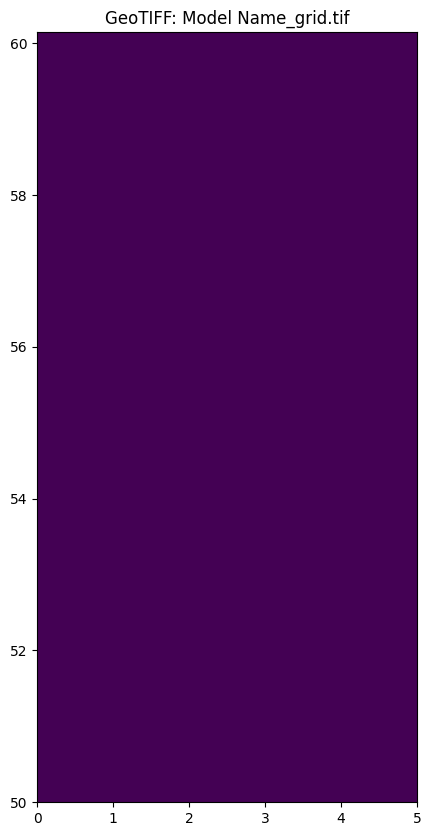

In [15]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt


tif_file = f"{model_name.value}_grid.tif"

# Open the GeoTIFF file
with rasterio.open(tif_file) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(src, ax=ax)
    plt.title(f"GeoTIFF: {tif_file}")
    plt.show()

# Putting everything together

put code of single tabs in own code cell, per tab --> to have it more structured!

In [12]:
###########################################################################################


@solara.component
def Tab3():
    
    with solara.Card("xxx3", style={"width": "100%", "padding": "10px"}):
        solara.Text("text")


@solara.component
def Tabxxx():
    
    with solara.Card("xxx", style={"width": "100%", "padding": "10px"}):
        solara.Text("text")

###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
selected_tab = solara.reactive('UserInput') 
@solara.component
def SettingsTabs():
    with solara.Column(style={"width": "100%", "align-items": "center"}):
        with solara.Row(gap="10px", style={"justify-content": "flex-start", "width": "80%"}):
            solara.Button("User Input", on_click=lambda: selected_tab.set('UserInput'))
            solara.Button("2", on_click=lambda: selected_tab.set('2'))
            solara.Button("3", on_click=lambda: selected_tab.set('3'))
        with solara.Row(gap="10px", style={"justify-content": "flex-start", "width": "80%"}):
            solara.Button("xxx", on_click=lambda: selected_tab.set('xxx'))
 
    if selected_tab.value == 'UserInput':
        Tab_User_Input()
    elif selected_tab.value == '2':
        Tab_Grid()
    elif selected_tab.value == '3':
        Tab3()
    elif selected_tab.value == 'xxx':
        Tabxxx()

@solara.component
def Page():
    with solara.Columns():
        with solara.Column(style={"width": "70%", "min-width": "650px"}):
            display(m.value) # m) # 

        with solara.Column(style={"width": "30%", "min-width": "500px"}):
            SettingsTabs()

Page()

Cannot show ipywidgets in text

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.